In [9]:
import pandas as pd
import json
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer
)

if torch.cuda.is_available():
    print(f"GPU found, using: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("GPU not found")
    device = torch.device("cpu")

GPU found, using: NVIDIA GeForce RTX 3070


In [10]:
CSV = '../../Data/Specialty-Data/specialty_data.csv'
MAPPINGS = '../../Data/Specialty-Data/specialty_data_label_mappings.json'
WEIGHTS = '../../Data/Specialty-Data/specialty_data_class_weights.json'

# Use absolute file path
MODEL = r"E:\Trend-Interview\Codebase\Model-Development\Specialty-Models\Saved-Models\BERT\microsoft\BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext\5-classes-unweighted-training_run_2025-11-08_20-52-22\final_model"
TEXT_COLUMN = 'transcription'

In [11]:
def tokenize_function(examples, tokenizer):
    """Tokenizes text data."""
    return tokenizer(
        examples[TEXT_COLUMN], 
        padding="max_length", 
        truncation=True,
        max_length=512
    )

In [12]:
# Configure dataframe

try:
    raw_df = pd.read_csv(CSV)
    with open(MAPPINGS, 'r') as f:
        specialty_and_id_map = json.load(f)
    with open(WEIGHTS, 'r') as f:
        class_weights = json.load(f)
except:
    print(f"Data not found, make sure to run the specialty_data_preprocessing.ipynb file in its entirety to retrieve the data")

id_to_label = {int(k): v for k, v in specialty_and_id_map['id_to_label'].items()}
label_names = [id_to_label[i] for i in range(len(id_to_label))]

df = raw_df[['transcription', 'medical_specialty', 'label']].dropna()

df

,transcription,medical_specialty,label
0,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary,0
1,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary,0
2,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiovascular / Pulmonary,0
3,"DESCRIPTION:,1. Normal cardiac chambers size....",Cardiovascular / Pulmonary,0
4,"2-D STUDY,1. Mild aortic stenosis, widely calc...",Cardiovascular / Pulmonary,0
...,...,...,...
1258,"EXAM: , Left heart cath, selective coronary an...",Cardiovascular / Pulmonary,0
1259,"INDICATION:, Acute coronary syndrome.,CONSENT...",Cardiovascular / Pulmonary,0
1260,"ANGINA, is chest pain due to a lack of oxygen ...",Cardiovascular / Pulmonary,0
1261,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...",Cardiovascular / Pulmonary,0


In [13]:
# 80% Train, 10% Validation, 10% Test

train_df, test_val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=0
)

val_df, test_df = train_test_split(
    test_val_df, 
    test_size=0.5, 
    stratify=test_val_df['label'], 
    random_state=0
)

ds = DatasetDict({
    'test': Dataset.from_pandas(test_df.reset_index(drop=True))
})

In [14]:
# Tokenize data

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

model.to(device)

tokenized_ds = ds.map(
    lambda examples: tokenize_function(examples, tokenizer), 
    batched=True
)

tokenized_ds['test'] = tokenized_ds['test'].remove_columns(
    [col for col in test_df.columns if col not in ['label', 'input_ids', 'attention_mask']]
)

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

In [15]:
# Create classification Report

trainer = Trainer(model=model, tokenizer=tokenizer)

raw_predictions = trainer.predict(tokenized_ds["test"])

predictions = np.argmax(raw_predictions.predictions, axis=1)
true_labels = raw_predictions.label_ids

report = classification_report(
    true_labels, 
    predictions, 
    target_names=label_names
)
print(report)

C:\Users\spenc\AppData\Local\Temp\ipykernel_15344\86285031.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.75      0.86      0.80        28
                  Radiology       0.58      0.56      0.57        25
                 Orthopedic       0.80      0.77      0.79        31
           Gastroenterology       0.82      0.95      0.88        19
 Consult - History and Phy.       0.74      0.58      0.65        24

                   accuracy                           0.74       127
                  macro avg       0.74      0.74      0.74       127
               weighted avg       0.74      0.74      0.74       127



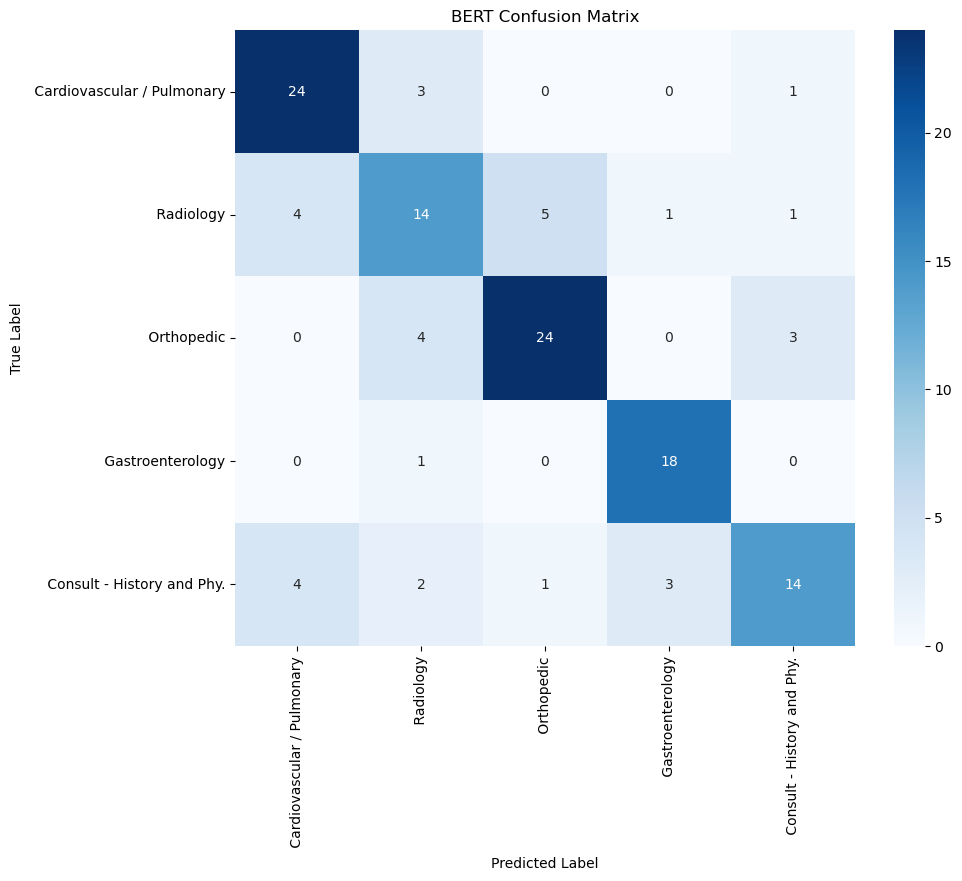

In [16]:
# Create confusion Matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=label_names, 
    yticklabels=label_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('BERT Confusion Matrix')

plt.show()